In [1]:
# Connect to google drive from colab to obtain necessary data
# Uncomment if you use it in colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
import numpy as np
from PIL import Image

### Download images from the web to google drive. Use only one time.

In [3]:
df = pd.read_csv("/content/drive/My Drive/players_photos.csv", sep=";")
df.head()

,Team,Photo
0,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...
1,Avalanche,https://cms.nhl.bamgrid.com/images/arena/defau...
2,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...
3,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...
4,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...


In [4]:
PATH = "/content/drive/My Drive/players_photos/"

In [ ]:
# Loop for downloading images from the web and save it in google drive

for i in tqdm(range(df.shape[0])):
  r = requests.get(df.iloc[i, 1], stream=True)
  class_ = df.iloc[i, 0]
  if class_ not in os.listdir(PATH):
    os.mkdir(os.path.join(PATH, class_))
  photo_name = "player_" + f"{i}" + ".jpg"
  with open(os.path.join(PATH, class_, photo_name), "wb") as file:
    for block in r.iter_content(chunk_size = 1024): 
      if block:  
        file.write(block)

100%|██████████| 885/885 [03:32<00:00,  4.17it/s]


### Obtain id from the image name to connect to the team in original dataframe

In [ ]:
def get_image_id(name):
  a = name.find("_")
  b = name.find(".")
  id = name[a+1:b]
  return int(id)

### Some data analysis

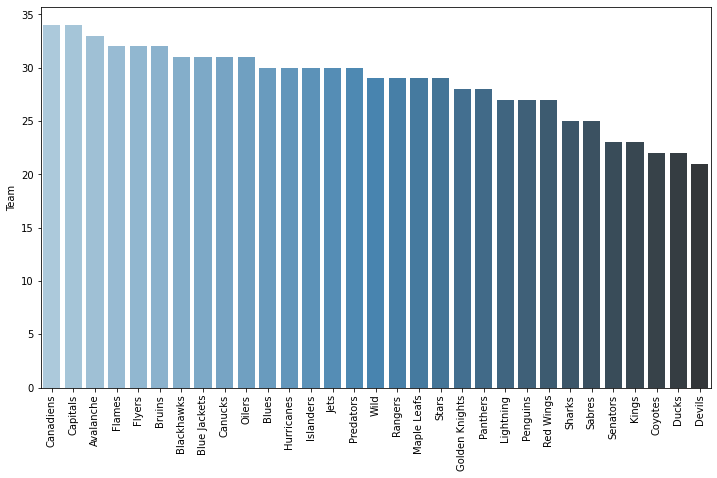

In [ ]:
plt.figure(figsize=(12, 7))
sns.barplot(x=df.loc[:, "Team"].value_counts().index, 
            y=df.loc[:, "Team"].value_counts(),
            palette="Blues_d")
plt.xticks(rotation="vertical");

In [5]:
# Assign each team to certain value
# E.g. Avalanche: 0, Blackhawks: 1, ...
# And reverse
# It can be useful in future tasks

team_names_sorted_list = sorted(list(set(df.iloc[:,0])))
team_class_dict = dict()
reverse_team_class_dict = dict()
for i in tqdm(range(len(team_names_sorted_list))):
  team = team_names_sorted_list[i]
  class_ = i
  team_class_dict[team] = class_
  reverse_team_class_dict[class_] = team

100%|██████████| 31/31 [00:00<00:00, 90545.56it/s]


### 1. Prepare data

In [25]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms

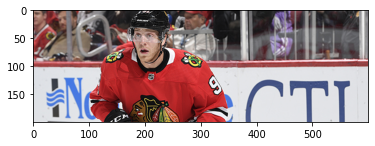

In [7]:
img = plt.imread("/content/drive/My Drive/players_photos/Blackhawks/player_33.jpg")
plt.imshow(img);

In [8]:
img.shape

(200, 600, 3)

#### Data processing

In [9]:
# Check how datasets.ImageFolder works
data = datasets.ImageFolder(root=PATH)

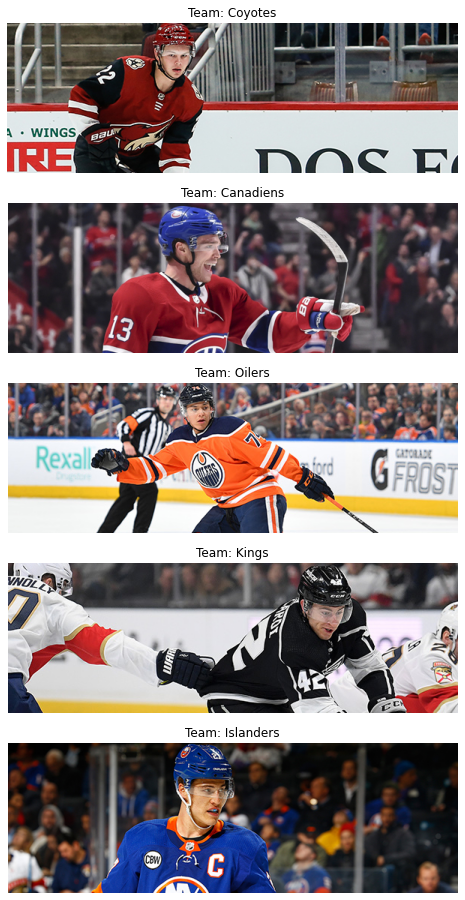

In [10]:
# Check image and assigning team
fig = plt.figure(figsize=(30, 16))
for i in range(5):
  data_point = np.random.randint(0, 885, 1)[0]
  pl = data[data_point]
  sub = fig.add_subplot(5, 1, i+1)
  sub.set_title(f"Team: {reverse_team_class_dict[pl[1]]}")
  plt.axis("off")
  plt.imshow(pl[0])
plt.show();

Looks fine... \
Create train and validation dataloaders

In [11]:
def get_train_and_valid_dataloaders(root, valid_size, batch_size, transform=None):
  # Create train and validation datasets from root folder
  train_data = datasets.ImageFolder(root=root, transform=transform)
  valid_data = datasets.ImageFolder(root=root, transform=transform)

  # Get indices for train and valid data
  num = len(train_data)
  indices = list(range(num))
  split = int(valid_size * num)
  np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  # Create samplers for dataloaders
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  # Create train and valid dataloaders
  traindataloader = DataLoader(train_data, 
                               batch_size=batch_size,
                               sampler=train_sampler)
  
  validdataloader = DataLoader(valid_data, 
                               batch_size=batch_size,
                               sampler=valid_sampler)
  
  return traindataloader, validdataloader

In [33]:
# Add augmentation

transform = transforms.Compose([
                                transforms.RandomGrayscale(p=0.2),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(45),
                                # transforms.RandomErasing(p=0.3),
                                transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5, 0.5, 0.5],
                                                     std = [0.5, 0.5, 0.5])
])

In [34]:
train_dataloader, valid_dataloader = get_train_and_valid_dataloaders(PATH,
                                                                     valid_size=0.2,
                                                                     batch_size=16,
                                                                     transform=transform)

In [31]:
print(len(valid_dataloader.dataset.classes))

31


### 2. Model creation

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's start with simple custom CNN

In [87]:
class NHLModel(nn.Module):
  def __init__(self, num_out):
    super(NHLModel, self).__init__()

    # Convolution part
    self.cnn = nn.Sequential(
        # 1st layer
        nn.Conv2d(3, 4, kernel_size=3, padding=2),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        # 2nd layer
        nn.Conv2d(4, 6, kernel_size=5, padding=2),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        # 3rd layer
        nn.Conv2d(6, 8, kernel_size=7, padding=2),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    # Linear part
    self.linear = nn.Sequential(
        nn.Linear(24 * 24 * 8, 10000),
        nn.ReLU(),
        nn.Linear(10000, 1000),
        nn.ReLU(),
        nn.Linear(1000, num_out)
    )


  def forward(self, x):

    x = self.cnn(x)
    x = x.view(-1, 24 * 24 * 8)
    x = self.linear(x)

    return x

In [80]:
class PerceptronModel(nn.Module):
  def __init__(self):
    super(PerceptronModel, self).__init__()
    
    self.linear = nn.Sequential(
        nn.Linear(120000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 100),
        nn.ReLU(),
        nn.Linear(100, 31)
    )

  def forward(self, x):

    x = x.view(-1, 120000)
    x = self.linear(x)

    return x

### 3. Training

In [88]:
# Define model
model = NHLModel(31).to(device)

# model = PerceptronModel().to(device)

In [92]:
# Optimizer, in our case is Adam
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [93]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

Define training process

In [94]:
num_epochs = 10
log_period = 1

for epoch in range(num_epochs):
  print(f"Start epoch: {epoch}")
  # Train the model
  model.train()
  # Set loss for training
  train_loss = 0
  # Set values to calculate acccuracy
  train_correct = 0
  train_total = 0
  for X, y in train_dataloader:
    # Put X and y to the device 
    X = X.to(device)
    y = y.to(device)
    # Make gradients equal to 0
    optimizer.zero_grad()
    # Make prediction
    predict = model(X)
    # Calculare loss
    loss = criterion(predict, y)
    # Perform backward pass
    loss.backward()
    # Optimize parameters
    optimizer.step()
    # Add loss value to overall train loss
    train_loss += loss.item()
    # Calculate accuracy
    predicted_idxs = torch.argmax(predict, dim=1)
    train_total += y.size(0)
    train_correct += (predicted_idxs == y).sum().item()
  # Set model to validation mode
  model.eval()
  # Set loss for validation
  valid_loss = 0
  # Set accuracy values for validation
  valid_correct = 0
  valid_total = 0
  with torch.no_grad():
    for X_val, y_val in valid_dataloader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)

      predict = model(X_val)
      loss = criterion(predict, y_val)
      valid_loss += loss.item()

      predicted_idxs = torch.argmax(predict, dim=1)
      valid_total += y_val.size(0)
      valid_correct += (predicted_idxs == y_val).sum().item()
  
  if epoch % log_period == 0:
    print(f"Epoch: {epoch}.")
    print(f"Train loss: {train_loss/len(train_dataloader)}. Valid loss: {valid_loss/len(valid_dataloader)}.")
    print(f"Train accuracy: {train_correct/train_total}. Valid accuracy: {valid_correct/valid_total}")


Start epoch: 0
Epoch: 0.
Train loss: 3.477819103664822. Valid loss: 3.468031883239746.
Train accuracy: 0.03954802259887006. Valid accuracy: 0.03409090909090909
Start epoch: 1
Epoch: 1.
Train loss: 3.4686227321624754. Valid loss: 3.4461565884676846.
Train accuracy: 0.03531073446327684. Valid accuracy: 0.028409090909090908
Start epoch: 2
Epoch: 2.
Train loss: 3.4686187002393933. Valid loss: 3.4342005903070625.
Train accuracy: 0.029661016949152543. Valid accuracy: 0.03409090909090909
Start epoch: 3
Epoch: 3.
Train loss: 3.470557106865777. Valid loss: 3.458338065580888.
Train accuracy: 0.026836158192090395. Valid accuracy: 0.022727272727272728
Start epoch: 4
Epoch: 4.
Train loss: 3.468018907970852. Valid loss: 3.4526438279585405.
Train accuracy: 0.01977401129943503. Valid accuracy: 0.028409090909090908
Start epoch: 5
Epoch: 5.
Train loss: 3.4638249556223553. Valid loss: 3.447718923742121.
Train accuracy: 0.03531073446327684. Valid accuracy: 0.017045454545454544
Start epoch: 6
Epoch: 6.
Tra

Do not forget to save model parameters!

In [ ]:
torch.save(model.state_dict(), "nhl_model.pth")

### 4. Validation of the model

In [ ]:
# Create model and download parameters for it
model2 = NHLModel(31)
model2.load_state_dict(torch.load("nhl_model.pth"))
model2.to(device)
model2.eval()

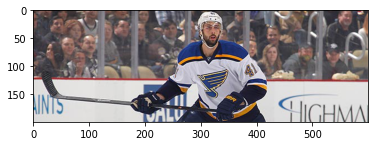

In [67]:
image_path = "/content/drive/My Drive/players_photos/Blues/player_112.jpg"
img = Image.open(image_path)
plt.imshow(img);

In [85]:
img2 = transform(img)
pr = model(img2.view(1, img2.shape[0], img2.shape[1], img2.shape[2]).to(device))

In [86]:
idx = torch.argmax(pr).item()
print(f"Predicted team: {reverse_team_class_dict[idx]}")

Predicted team: Capitals


Trained model always returns the same probability distribution!
Some ideas to solve:
* More data augmentation
* Change loss and learning rate
* Change batch size
* Change architecture of the network
* Try to use pretrained model (will it help?)